In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from importlib import reload
import matplotlib.pyplot as plt

import utils.models as models
import utils.plotting as plotting
import utils.dataloaders as dl
import utils.traintest as tt
import utils.adversarial as adv
import utils.eval as ev
import model_params as params
import utils.resnet_orig as resnet
import utils.gmm_helpers as gmm_helpers

from tensorboardX import SummaryWriter
%load_ext line_profiler

In [2]:
device = torch.device('cuda:6')
base_model = torch.load('SavedModels/base/base_CIFAR10_lr0.1_augm_flagTrue_train_typeplain.pth')
#base_model = resnet.ResNet18()
gmm = torch.load('SavedModels/GMM/gmm_CIFAR10_n1000_data_used50000_augm_flagTrue_alg_scikit.pth')
#model_joint = torch.load('SavedModels/gmm_CIFAR10_lam1817.2447973632814_n1000_lr0.1_augm_flagTrue_train_typeplaingrad_vars mu.pth').to(device)
model_params = params.params_dict['CIFAR10'](augm_flag=True, batch_size=128)

Using downloaded and verified file: ../data/test_32x32.mat


In [ ]:
gmm_helpers.rescale(gmm, 1, model_params.cali_loader)

In [ ]:
lam = gmm_helpers.find_lam(gmm, 1., model_params.cali_loader)
print(lam)

In [ ]:
gmm.mu.requires_grad = True
gmm.logvar.requires_grad = True
gmm.alpha.requires_grad = (False)

model = models.RobustModel(base_model, gmm, lam, dim=model_params.dim).to(device)
model.loglam.requires_grad = False


In [73]:
lr = 0.1

param_groups = [{'params':model.mm.mu,'lr':lr, 'weight_decay':0.},
                {'params':model.mm.logvar,'lr':0.1*lr, 'weight_decay':0.},
                {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':5e-4}]
optimizer = optim.SGD(param_groups,  momentum=.9)

In [74]:
for epoch in range(5):
    if epoch+1 in [50,75,90]:
        for group in optimizer.param_groups:
            group['lr'] *= .1
    
    trainloss = tt.train_CEDA(model, device, model_params.cali_loader, 
                                  model_params.loaders[-1][1], 
                                  optimizer, epoch, verbose=100)
    print( model.mm.logvar.exp().sqrt().mean() )

Train Epoch: 0 [0/50000 (0%)]	Loss: 4.232345
Train Epoch: 0 [12800/50000 (26%)]	Loss: 2.201652
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.914012
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.603652
tensor(13.7980, device='cuda:6', grad_fn=<MeanBackward1>)
Train Epoch: 1 [0/50000 (0%)]	Loss: 1.745894
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.578573
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.451692
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.472865
tensor(13.7980, device='cuda:6', grad_fn=<MeanBackward1>)
Train Epoch: 2 [0/50000 (0%)]	Loss: 1.408381
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.595599


Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/queues.py", line 247, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.5/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, b

KeyboardInterrupt: 

In [4]:
e = enumerate(model_params.test_loader)

In [50]:
data, label = e.__next__()[1]

NameError: name 'e' is not defined

In [70]:
model.mm.logvar.exp().sqrt().mean()

tensor(13.7804, device='cuda:6', grad_fn=<MeanBackward1>)

In [50]:
print(tt.test(model.base_model, device, model_params.test_loader) )
print(tt.test(model, device, model_params.test_loader) )
print(tt.test(model_joint.base_model, device, model_params.test_loader) )
print(tt.test(model_joint, device, model_params.test_loader) )

(0.9449, 0.9779834579467773, 0.21270767068862914)
(0.9336, 0.9672730545043945, 0.2371864013671875)
(0.9465, 0.976639998626709, 0.204542000579834)
(0.9357, 0.9663634201049804, 0.22866175537109376)


In [14]:
y = []
X = []
target = []
for i, (x, t) in enumerate(model_params.cali_loader):
    if i>10:
        break;
    X.append(x)
    target.append(t)
    y.append(torch.logsumexp(gmm(x.view(-1,gmm.D)),0).detach() )
X = torch.cat(X, 0)
y = torch.cat(y, 0)
target = torch.cat(target, 0)

RuntimeError: expected type torch.FloatTensor but got torch.cuda.FloatTensor

In [51]:
_, (data, target) = enumerate(model_params.cali_loader).__next__()
data, target = data.to(device), target.to(device)

In [ ]:
for i in torch.nonzero(y<model.loglam.cpu()).squeeze():
    plt.imshow(X[i].cpu().permute(1,2,0))
    plt.show()

In [201]:
data= X[torch.nonzero(y<model.loglam.cpu()).squeeze()]
t = target[torch.nonzero(y<model.loglam.cpu()).squeeze()]

In [304]:
lr = 0.1
param_groups = [{'params':model.mm.parameters(),'lr':lr, 'weight_decay':0.},
                {'params':model.base_model.parameters(),'lr':lr, 'weight_decay':5e-4}]
optimizer = optim.SGD(param_groups,  momentum=.9)
criterion = nn.NLLLoss()

In [81]:
_, (data, target) = enumerate(model_params.cali_loader).__next__()
noise = enumerate(noise_loader).__next__()[1][0]
data, target = data.to(device), target.to(device)

noise = noise.to(device)

criterion = nn.NLLLoss()
optimizer.zero_grad()
output = model(data)

output_adv = model(noise)
        
loss = F.nll_loss(output, target) - output_adv.max(1)[0].sum()/(noise_loader.batch_size)

print(loss)
loss.backward()
print(model.mm.mu.grad.abs().max())
print(model.mm.logvar.grad.abs().max(0))

tensor(1.2099, device='cuda:6', grad_fn=<SubBackward0>)
tensor(0., device='cuda:6')
(tensor(0., device='cuda:6'), tensor(0, device='cuda:6'))


In [65]:
noise_loader = model_params.loaders[-1][1]

In [54]:
for p in optimizer.param_groups[1]['params']:
    if p.grad is not None:
        print(p.grad.abs().max())
    else:
        print('None')

tensor(0., device='cuda:6')


tensor(0., device='cuda:6')

In [232]:
torch.logsumexp( model.mm(data.view(data.shape[0], -1)), 0)

tensor([-645.9120, -688.6625, -704.2325, -822.0087, -811.4551, -698.0391,
        -690.4484, -716.3196, -705.8167, -653.5068],
       grad_fn=<LogsumexpBackward>)

In [244]:
model.loglam.data = torch.tensor(-819.1827294921875)

In [221]:
gmm.logvar.requires_grad = (True)

In [382]:
loglam_vec = torch.linspace(-835, -815, 25)
lossv = []
mug = []
varg = []
alphag = []
ang = []
pred = []
for loglam in loglam_vec:
    model.loglam.data = loglam
    optimizer.zero_grad()
    output = model(data2)
    
    loss = criterion(output, t2)
    loss.backward()
    
    lossv.append(loss.detach())
    
    a = (model.mm.mu[827]-data2[0].view(-1)).detach().numpy()
    b = (model.mm.mu.grad[827]).detach().numpy()
    ang.append( ( a*b ).sum()/(np.linalg.norm(a)*np.linalg.norm(b)) )
    pred.append(output.detach().numpy())
    mug.append((model.mm.mu.grad[827]**2).sum().detach())
    varg.append(model.mm.logvar.grad[827].detach().item())
    alphag.append(model.mm.alpha.grad[827].detach().item())

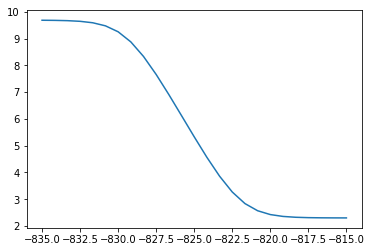

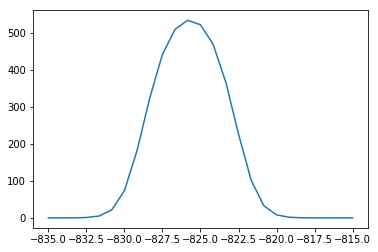

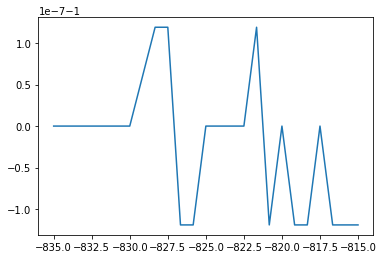

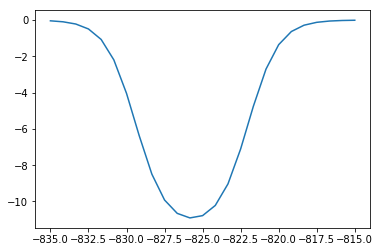

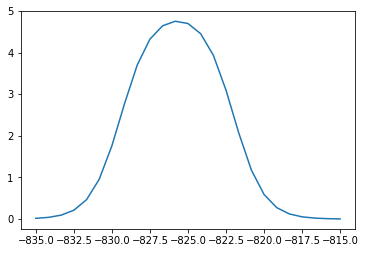

In [383]:
plt.plot(loglam_vec.numpy(), np.array(lossv))
plt.show()
plt.plot(loglam_vec.numpy(), np.array(mug))
plt.show()
plt.plot(loglam_vec.numpy(), np.array(ang))
plt.show()
plt.plot(loglam_vec.numpy(), .01*np.array(varg))
plt.show()
plt.plot(loglam_vec.numpy(), 5*np.array(alphag))
plt.show()

In [369]:
torch.tensor(pred[-1].max()).exp()

tensor(0.9999)

In [373]:
(pred[1]- pred[24]).shape

(10, 10)

In [377]:
t2 = torch.tensor([2,2])

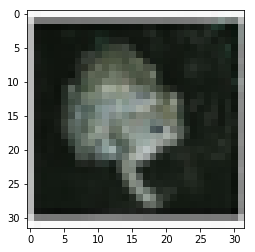

In [326]:
plt.imshow(data2[0].permute(1,2,0))

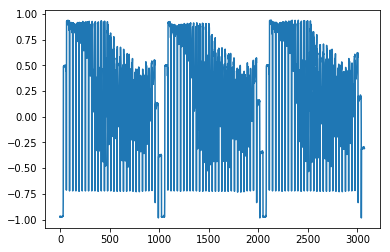

In [329]:
plt.plot((model.mm.mu[827]-data2[0].view(-1)).detach().numpy())

In [337]:
a = (model.mm.mu[827]-data2[0].view(-1)).detach().numpy()
b = (model.mm.mu.grad[827]).detach().numpy()
( a*b ).sum()/(np.linalg.norm(a)*np.linalg.norm(b))

0.6867988

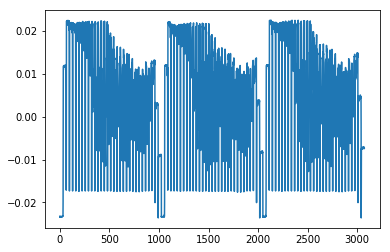

In [275]:
plt.plot((model.mm.mu.grad[827]).detach().numpy())

In [350]:
(model.mm(data2.view(2,-1))>-840.).float().sum()

tensor(2.)

In [376]:
torch.nonzero(y<model.loglam.cpu()).squeeze()

tensor([], dtype=torch.int64)